In [15]:

import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy.signal import resample

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, linregress
import random
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.python.client import device_lib
import matplotlib.colors as mcolors
from scipy.stats import norm

In [3]:
MODEL_NAME = '3_inputs_model'
RUN = 'run6_' + MODEL_NAME+ '/'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/dataset/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Fantasia_respiration/dataset/
/nfs/ada/jbrook1/users/qdang1/Fantasia_respiration/output/run6_3_inputs_model/


# Load Data

In [4]:
data_df = pd.read_pickle(DATA_DIR + 'fantasia_dataset_preprocessing.plk')
data_df

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough,hr_min,hr_mean,hr_max,hrv,snr
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...",14.505123,0.562117,1.169217,1.690667,2.544000,59.055118,62.032517,66.371681,16.625697,5.385646
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...",15.780254,1.146417,0.315799,1.525143,2.221333,58.593750,62.245654,66.079295,16.559194,5.984316
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...",13.284661,0.353985,0.445506,1.772000,2.860000,57.692308,59.618603,61.728395,8.315218,6.507062
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...",14.913591,0.688938,1.089432,1.680000,2.391000,32.894737,62.955495,69.124424,261.545152,6.893892
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...",16.444328,0.983089,0.837500,1.479200,2.752000,57.251908,62.337664,67.264574,14.326248,5.866205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9469,f2y10,232,"[-0.10009765625, -0.09765625, -0.10009765625, ...","[0.0048828125, 0.0048828125, 0.0048828125, 0.0...",14.497019,0.197665,0.101241,1.556800,2.480000,52.631579,58.396608,66.079295,66.171494,6.985175
9470,f2y10,233,"[-0.185546875, -0.1806640625, -0.18310546875, ...","[-0.126953125, -0.12939453125, -0.126953125, -...",12.471924,0.304567,0.516003,1.549600,3.345000,51.369863,58.250585,65.789474,56.823614,7.723637
9471,f2y10,234,"[-0.01708984375, -0.01220703125, -0.01953125, ...","[0.54443359375, 0.5419921875, 0.5517578125, 0....",15.151441,0.219147,0.206771,1.567200,2.387000,49.180328,56.770476,62.761506,542.688370,6.556642
9473,f2y10,236,"[0.1025390625, 0.07568359375, 0.0439453125, 0....","[-0.185546875, -0.185546875, -0.1806640625, -0...",14.860658,0.272106,0.304594,1.684667,2.696000,50.000000,56.347270,64.655172,63.884896,7.360403


In [12]:
sorted_data = data_df[data_df['Mean_Respiration_Rate'] < 15]
sorted_data = sorted_data.sort_values(by=['Mean_Respiration_Rate'])
sorted_data

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough,hr_min,hr_mean,hr_max,hrv,snr
244,f1o02,3,"[8.036, 7.988, 8.036, 8.084, 8.048, 8.036, 8.0...","[8.028, 8.02, 8.044, 8.072, 8.04, 8.016, 8.028...",7.047592,2.664780,0.438241,1.681000,6.785333,60.975610,62.496902,64.377682,12.212406,6.746932
1045,f1o05,81,"[7.976, 8.428, 8.7, 8.176, 7.888, 8.256, 8.6, ...","[7.812, 7.86, 7.88, 7.844, 7.824, 7.896, 7.884...",7.423508,0.806877,2.095880,2.371000,5.596000,52.631579,54.871678,57.915058,13.362634,6.085740
2958,f1y03,101,"[8.18, 8.132, 8.188, 8.184, 8.176, 8.164, 8.17...","[8.38, 8.384, 8.356, 8.376, 8.368, 8.384, 8.34...",7.596490,0.967012,1.011230,2.416000,5.184000,56.603774,63.070669,72.115385,33.309417,8.006996
4348,f1y09,41,"[7.92, 7.852, 8.192, 8.876, 9.204, 9.576, 10.2...","[8.188, 8.244, 8.224, 8.176, 8.248, 8.18, 8.20...",7.639897,4.161349,3.195481,3.570000,3.817333,55.350554,71.706354,84.745763,43.573692,7.094445
9323,f2y10,86,"[0.4931640625, 0.458984375, 0.4296875, 0.41015...","[0.2294921875, 0.224609375, 0.2197265625, 0.21...",7.920548,0.766726,1.700597,3.115000,3.568000,54.744526,60.391759,75.376884,39.252271,5.139899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3438,f1y05,98,"[7.82, 8.136, 8.224, 7.92, 7.784, 8.1, 8.292, ...","[7.12, 7.18, 7.116, 7.172, 7.124, 7.168, 7.128...",14.988367,0.104450,0.736876,1.719000,2.158667,50.000000,56.037952,71.090047,72.416573,7.573675
7372,f2y02,20,"[-0.13780593893284393, -0.14448533387702703, -...","[0.2990683324360734, 0.3010795605128317, 0.297...",14.990632,0.402836,0.314640,1.410667,2.602400,48.076923,53.366140,57.915058,70.767224,11.028594
6075,f2o06,119,"[-0.17822265625, -0.17333984375, -0.17578125, ...","[-0.01708984375, -0.01953125, -0.009765625, -0...",14.991357,0.514357,0.491241,1.557600,2.540000,41.551247,44.020299,46.583851,29.257478,7.573508
4194,f1y08,130,"[8.004, 7.932, 7.856, 7.86, 7.928, 7.764, 7.58...","[9.34, 9.28, 9.292, 9.332, 9.36, 9.312, 9.28, ...",14.995732,1.258429,0.953113,2.353000,2.013333,57.251908,62.498102,68.493151,44.241760,8.022618


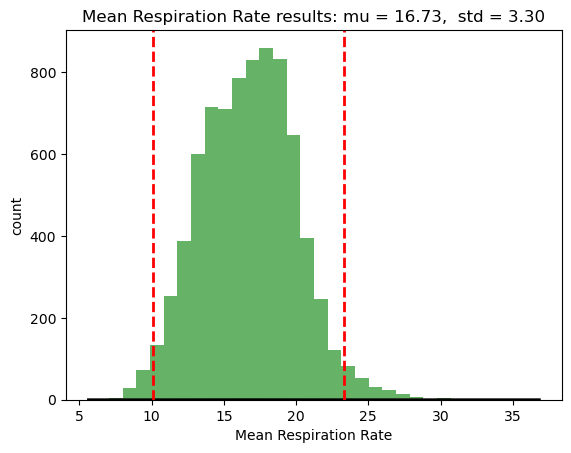

In [19]:
mean_respiration_rate = data_df['Mean_Respiration_Rate'].dropna()  # Drop NaN values for the histogram

# Plot the histogram
count, bins, ignored = plt.hist(mean_respiration_rate, bins=30, density=False, alpha=0.6, color='g')

# Fit a normal distribution to the data
mu, std = norm.fit(mean_respiration_rate)

# Plot the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add vertical lines for -/+ 2 std
plt.axvline(mu - 2*std, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mu + 2*std, color='r', linestyle='dashed', linewidth=2)

title = f"Mean Respiration Rate results: mu = {mu:.2f},  std = {std:.2f}"
plt.title(title)

plt.xlabel('Mean Respiration Rate')
plt.ylabel('count')
plt.show()

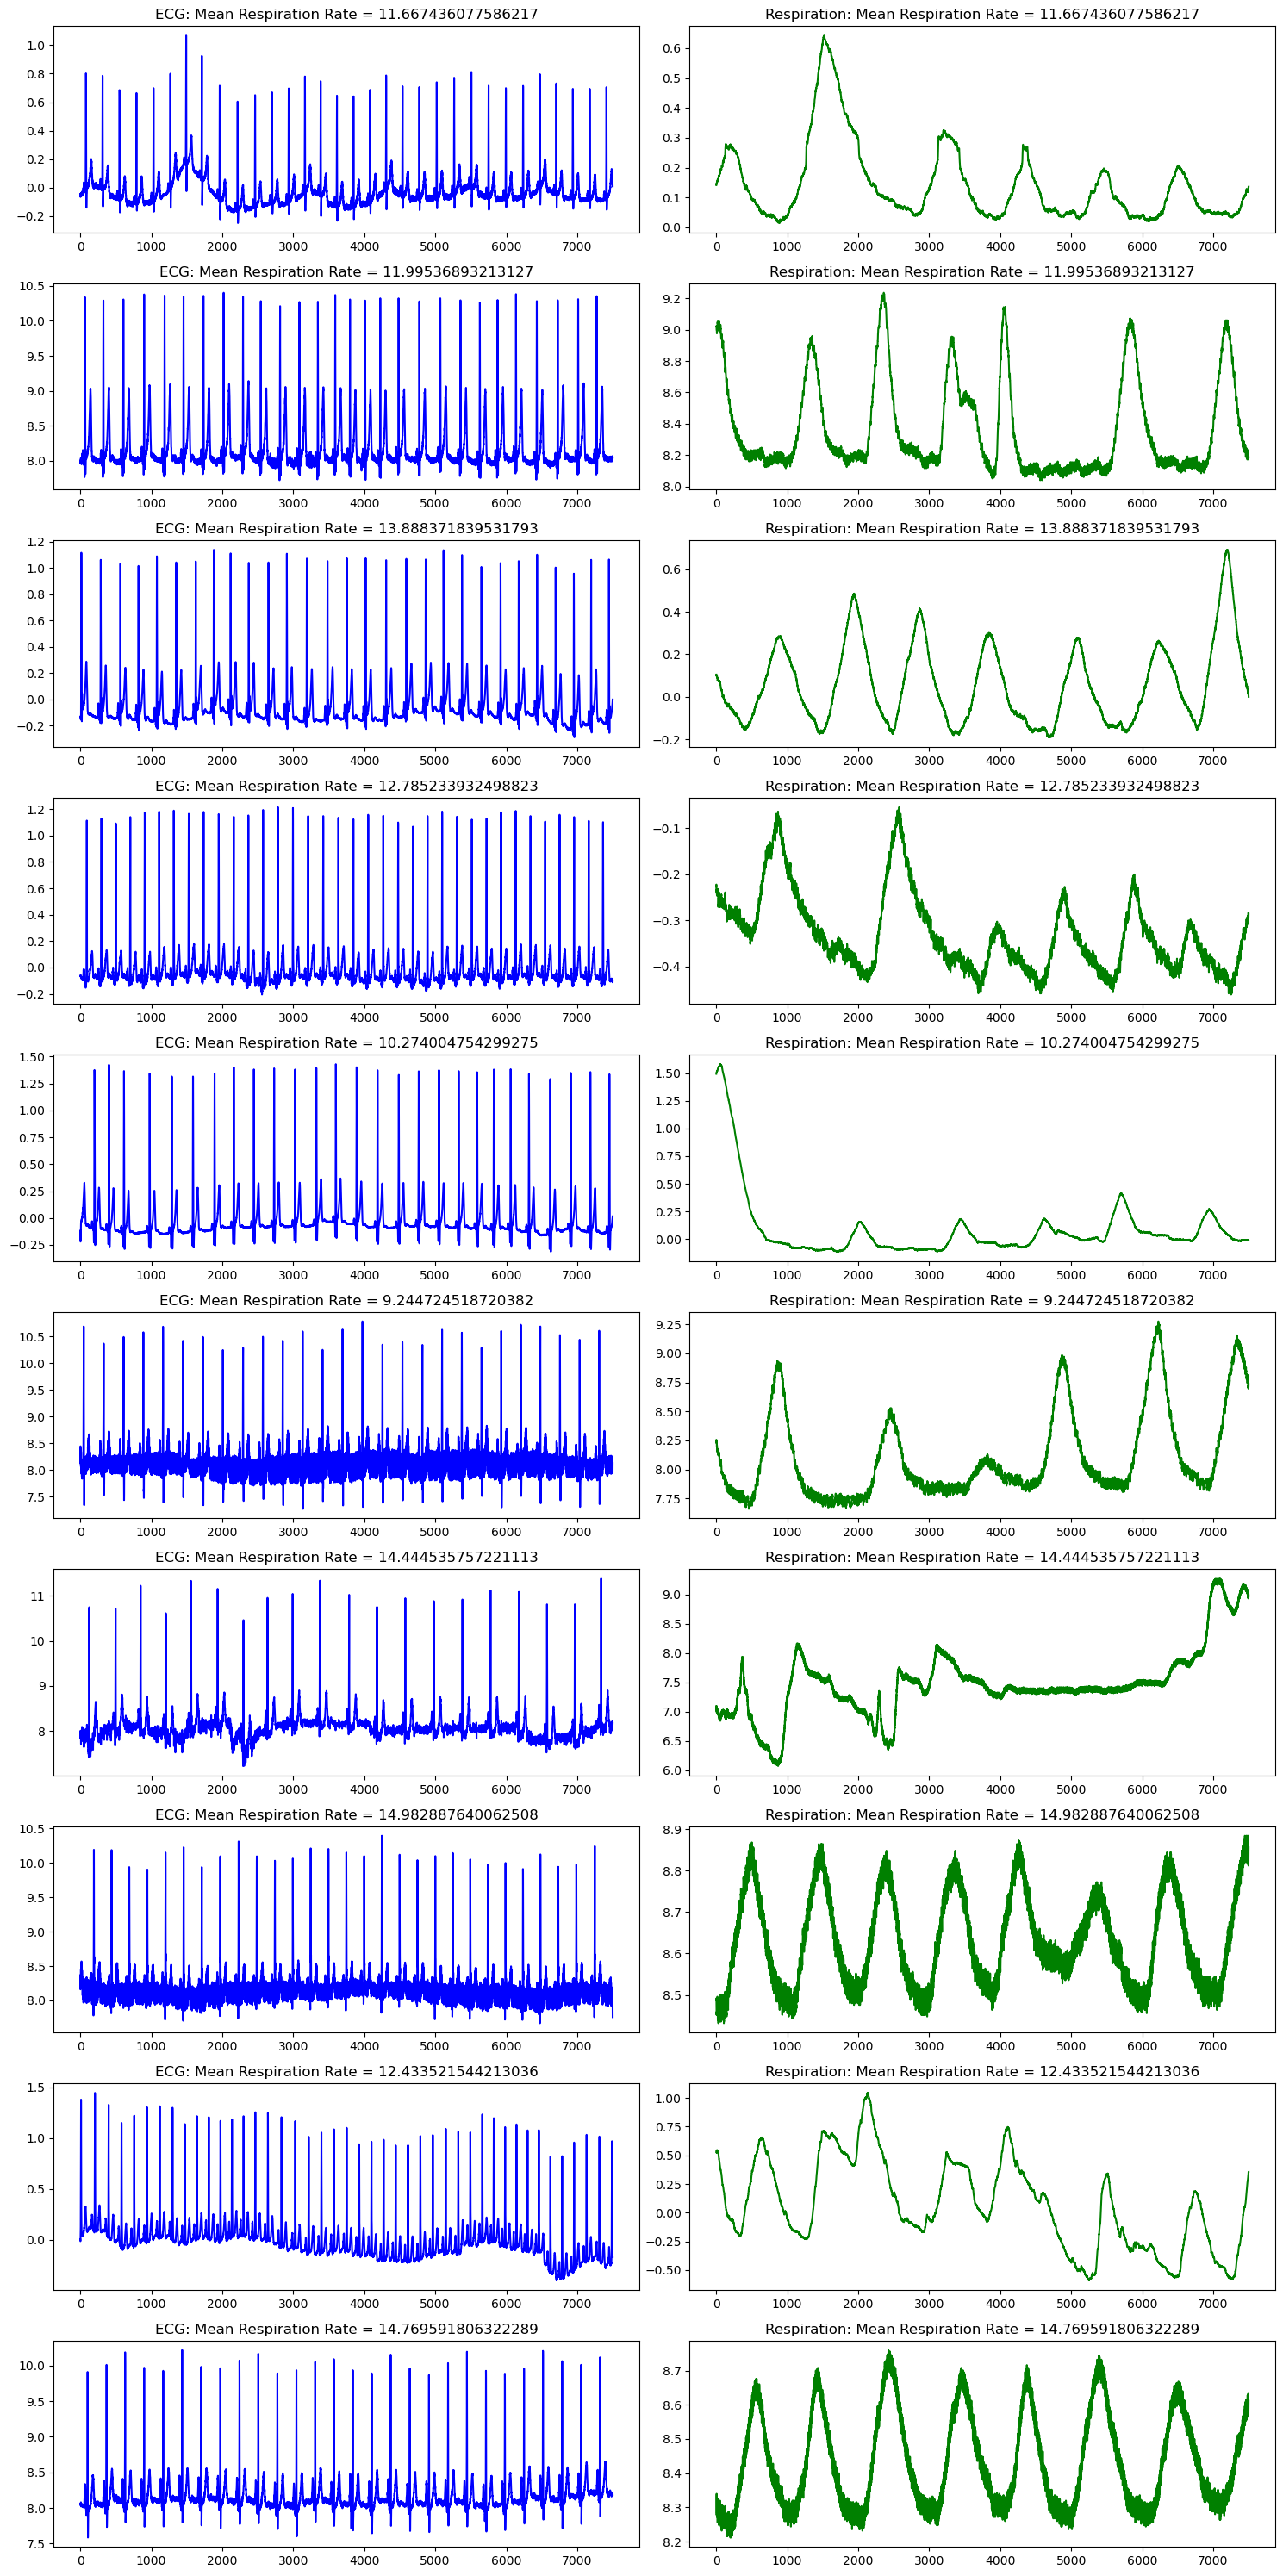

In [25]:

# Sample DataFrame
# df = pd.DataFrame({
#     'resp': [list_of_int1, list_of_int2, ..., list_of_intN],
#     'ecg': [list_of_int1, list_of_int2, ..., list_of_intN],
#     'Mean_Respiration_Rate': [rate1, rate2, ..., rateN]
# })  # Replace with your actual DataFrame

# Assuming sorted_data is already defined and contains the columns 'resp', 'ecg', and 'Mean_Respiration_Rate'
sorted_data = sorted_data[['resp', 'ecg', 'Mean_Respiration_Rate']]

# Randomly select 10 indices
random_indices = random.sample(range(len(sorted_data)), 10)

# Plot
fig, axes = plt.subplots(10, 2, figsize=(15, 30))  # Create a 10x2 grid of subplots

for i, idx in enumerate(random_indices):
    resp = sorted_data.iloc[idx]['resp']
    ecg = sorted_data.iloc[idx]['ecg']
    mean_resp_rate = sorted_data.iloc[idx]['Mean_Respiration_Rate']
    
    # Plot 'resp'
    axes[i, 0].plot(ecg, color='b')
    axes[i, 0].set_title(f'ECG: Mean Respiration Rate = {mean_resp_rate}')
    
    # Plot 'ecg'
    axes[i, 1].plot(resp, color='g')
    axes[i, 1].set_title(f'Respiration: Mean Respiration Rate = {mean_resp_rate}')

plt.tight_layout()
plt.show()
